In [14]:
import auxfunctions as aux
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import cv2
import imageio.v3 as iio
import sklearn as sk
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import sklearn.cluster


In [15]:
@aux.measure_time
def quantize(img_path, txt=""):
    img = cv2.imread(img_path)
    aux.plot_3d_hist(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), "before_quantization")
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    r, g, b = r.flatten(), g.flatten(), b.flatten()
    # plot_3d_hist(img)
    transformed_points = aux.trasform_points(r.flatten(), g.flatten(), b.flatten())

    weights = transformed_points[:, 2]
    # normalize weights
    weights = weights / np.max(weights)
    weights = weights ** 2
    X = transformed_points[:, :2][::10][weights[::10] > 0.5]
    kmeans = sklearn.cluster.DBSCAN(eps=0.1, min_samples=7, p=1.5)
    kmeans.fit(X, sample_weight=weights[::10][weights[::10] > 0.5])
        # Get unique labels (including noise points)
    labels = kmeans.labels_

    # Exclude noise points (-1 label) from cluster centers
    unique_labels = set(labels) - {-1}

    # Compute cluster centers
    cluster_centers = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        cluster_center = np.mean(cluster_points, axis=0)
        cluster_centers.append(cluster_center)
        print("Cluster with label {} has center {}".format(label, cluster_center))

    print("Number of clusters (excluding noise points):", len(cluster_centers))
    cluster_centers = np.array(cluster_centers)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, c='r')
    ax.set_title('DBSCAN clusters')
    plt.savefig(f"{img_path}_DBSCAN_DBSCAN_{txt}.png")

    lines = aux.polar_to_line(cluster_centers[:, 0], cluster_centers[:, 1], 300)
    new_points = aux.transform_points_to_lines((r, g, b), lines)
    new_img = np.zeros_like(img)
    new_img = new_points.reshape(new_img.shape)
    new_img = (new_img / np.max(new_img)) * 255

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_img_colored = cv2.cvtColor(new_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    aux.plot_3d_hist(new_img_colored, "after_quantization")
    aux.plot_2_images(img, new_img_colored)

    # write to a file
    cv2.imwrite("new_img.jpg", new_img)

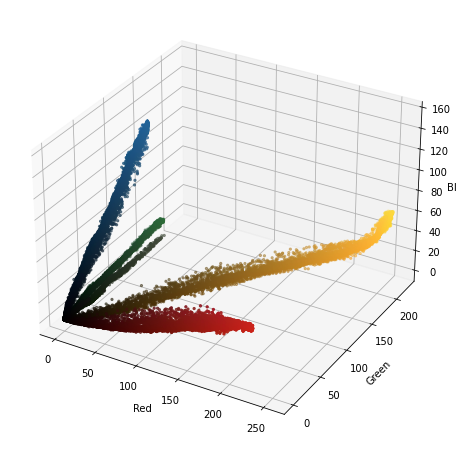

Cluster with label 0 has center [1.148  0.7393]
Cluster with label 1 has center [0.9243 1.45  ]
Cluster with label 2 has center [1.314 1.381]
Cluster with label 3 has center [0.5845 0.2059]
Number of clusters (excluding noise points): 4


In [ ]:
quantize("media for readme/colored balls.png", "red_ball")